In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
print("hello")

hello


In [2]:
temp=['AAPL','AMZN','GOOG','MSFT','TSLA']
start_date='2015-08-09'
end_date='2025-08-09'
df=yf.download('SPY',start_date,end_date,threads=True,progress=True)[["Close"]]

/var/folders/y7/hf6140q96774323j7d756khw0000gn/T/ipykernel_6032/232763807.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df=yf.download('SPY',start_date,end_date,threads=True,progress=True)[["Close"]]
[*********************100%***********************]  1 of 1 completed


In [3]:
df=df.stack().reset_index()
df['MA_10']=df['Close'].rolling(10).mean()
df['MA_30']=df['Close'].rolling(30).mean()

df['Signal']=np.where((df['Close']>df['MA_10'])&(df['Close']>df['MA_30']),1,0)
df['Returns']=(df['Close'].pct_change())
df['Strategy Returns']=df['Returns']*df['Signal'].shift(1)
df.dropna(inplace=True)
df

/var/folders/y7/hf6140q96774323j7d756khw0000gn/T/ipykernel_6032/316862407.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df=df.stack().reset_index()


Price,Date,Ticker,Close,MA_10,MA_30,Signal,Returns,Strategy Returns
29,2015-09-21,SPY,166.471680,166.330356,168.393545,0,0.005168,0.000000
30,2015-09-22,SPY,164.310928,166.118614,167.953741,0,-0.012980,-0.000000
31,2015-09-23,SPY,164.048203,166.103145,167.558570,0,-0.001599,-0.000000
32,2015-09-24,SPY,163.455078,165.939009,167.136602,0,-0.003616,-0.000000
33,2015-09-25,SPY,163.412674,165.695604,166.720526,0,-0.000259,-0.000000
...,...,...,...,...,...,...,...,...
2510,2025-08-04,SPY,631.169983,632.621997,623.947335,0,0.015200,0.000000
2511,2025-08-05,SPY,627.969971,632.532996,624.874666,0,-0.005070,-0.000000
2512,2025-08-06,SPY,632.780029,632.389996,625.741333,1,0.007660,0.000000
2513,2025-08-07,SPY,632.250000,632.172998,626.579000,1,-0.000838,-0.000838


<Axes: xlabel='Date'>

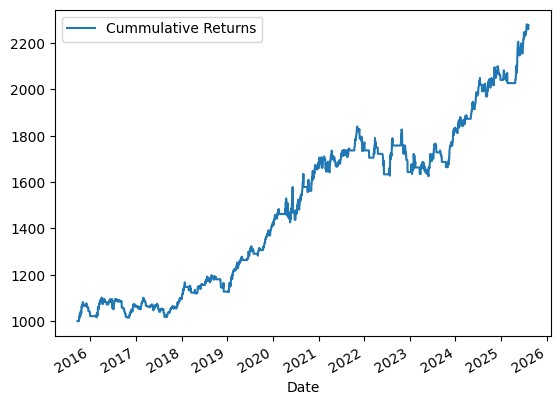

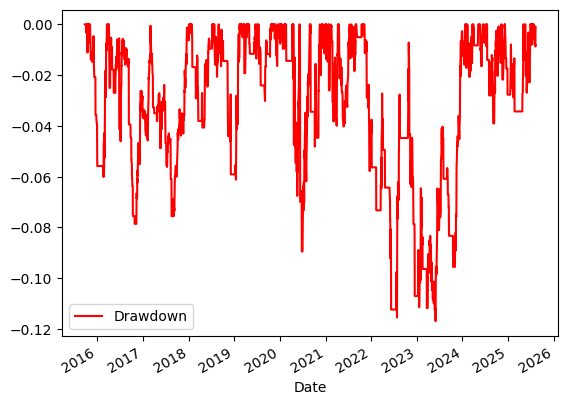

In [4]:
initial=1000
df['Cummulative Returns']=(df['Strategy Returns']+1).cumprod()*initial
df['Cummulative_max']=df['Cummulative Returns'].cummax()
df.plot(x='Date',y='Cummulative Returns',kind='line')
df['Drawdown']=(df['Cummulative Returns']/df['Cummulative_max'].cummax())-1
df.plot(x='Date',y='Drawdown',kind='line',color='red')


In [5]:
df['Strategy Returns'].describe()
# Calculate the daily standard deviation of the strategy's returns
daily_volatility = df['Strategy Returns'].std()

# Annualize the volatility
annualized_volatility = daily_volatility * np.sqrt(252)

print(f"Annualized Volatility: {annualized_volatility:.2%}")
# --- Step 1: Calculate Annualized Volatility (from above) ---
annualized_volatility = df['Strategy Returns'].std() * np.sqrt(252)


# --- Step 2: Calculate Annualized Return ---
# Get the mean daily return
mean_daily_return = df['Strategy Returns'].mean()

# Annualize the return
annualized_return = mean_daily_return * 252


# --- Step 3: Calculate Sharpe Ratio ---
# Set the risk-free rate (e.g., return on a U.S. Treasury bill). It's often set to 0 for simplicity.
risk_free_rate = 0.0

# Calculate the Sharpe Ratio
if annualized_volatility != 0:
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
else:
    sharpe_ratio = 0

print(f"Annualized Return: {annualized_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Annualized Volatility: 8.78%
Annualized Return: 8.74%
Sharpe Ratio: 0.99


In [6]:
def run_backtest(price_series,initial_capital=1000):
    df_bt=pd.DataFrame()
    df_bt['Close']=price_series
    df_bt['MA_10']=df_bt['Close'].rolling(10).mean()
    df_bt['MA_30']=df_bt['Close'].rolling(30).mean()
    df_bt['Signal']=np.where((df_bt['Close']>df_bt['MA_10'])&(df_bt['Close']>df_bt['MA_30']),1,0)
    df_bt['Returns']=(df_bt['Close'].pct_change())
    df_bt['Strategy Returns']=df_bt['Returns']*df_bt['Signal'].shift(1)
    df_bt.dropna(inplace=True)
    df_bt['Cummulative Returns']=(df_bt['Strategy Returns']+1).cumprod()*initial_capital
    df_bt['Cummulative_max']=df_bt['Cummulative Returns'].cummax()
    df_bt['Drawdown']=(df_bt['Cummulative Returns']/df_bt['Cummulative_max'].cummax())-1
    return df_bt
log_returns=np.log(df['Close']/df['Close'].shift(1)).dropna()

In [10]:
print(log_returns)

30     -0.013065
31     -0.001600
32     -0.003622
33     -0.000259
34     -0.025417
          ...   
2510    0.015085
2511   -0.005083
2512    0.007631
2513   -0.000838
2514    0.007767
Name: Close, Length: 2485, dtype: float64


In [7]:
num_paths=5
num_days=len(df)
 
start_price=df['Close'].iloc[-1]
simulated_paths=[]

for _ in range(num_paths):
    for _ in range(num_days):
        random_number=np.random.choice(log_returns,size=num_days,replace=True)
        path =start_price*np.exp(np.cumsum(random_number))
        simulated_paths.append(path)
simulated_paths[1]

array([ 638.56742323,  639.8817299 ,  638.77934763, ..., 3237.1968273 ,
       3234.11128973, 3238.29098271], shape=(2486,))

In [8]:
# import plotly.graph_objects as go
# import plotly.express as px
# from plotly.subplots import make_subplots
# fig=go.Figure()
# for path in simulated_paths:
#     fig.add_trace(go.Scatter
#                   (y=path,mode='lines',line=dict(color='blue',width=0.5)))
# fig.update_layout(
#     title='Monte Carlo Simulation',
#     xaxis_title='Days',
#     yaxis_title='Price',
#     template='presentation',
#     height=500
# )
# fig.show()
